<a href="https://colab.research.google.com/github/AshandPeach/KAGGLE/blob/main/traffic_sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 卷积神经网络（Convolutional Neural Network, CNN）

## 项目：计算机视觉 - 交通标志识别

### 项目内容

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 0](#step0): 图像数据预览
* [Step 1](#step1): 导入数据集
* [Step 2](#step2): 数据增强
* [Step 3](#step3): CNN模型构建
* [Step 4](#step4): 模型训练
* [Step 5](#step5): 测试你的算法

在该项目中包含了如下的问题：

* [问题 1](#question1): 使用类别不均衡的训练样本进行机器学习模型的训练
* [问题 2](#question2): 早期停止与学习率衰减的原理。
* [问题 3](#question3): 采用哪些方法可以进一步提高模型的准确度？

---
<a id='step0'></a>
## 步骤 0: 数据预览

### 图像数据

图像数据格式为 `ppm`，无法直接预览，我们使用 `PIL` 库中的 `Image` 函数对 `ppm` 格式图像进行处理。

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# !unzip '/content/drive/MyDrive/kaggle/traffic_sign/trafficsign.zip' -d '/content/drive/MyDrive/kaggle/traffic_sign'

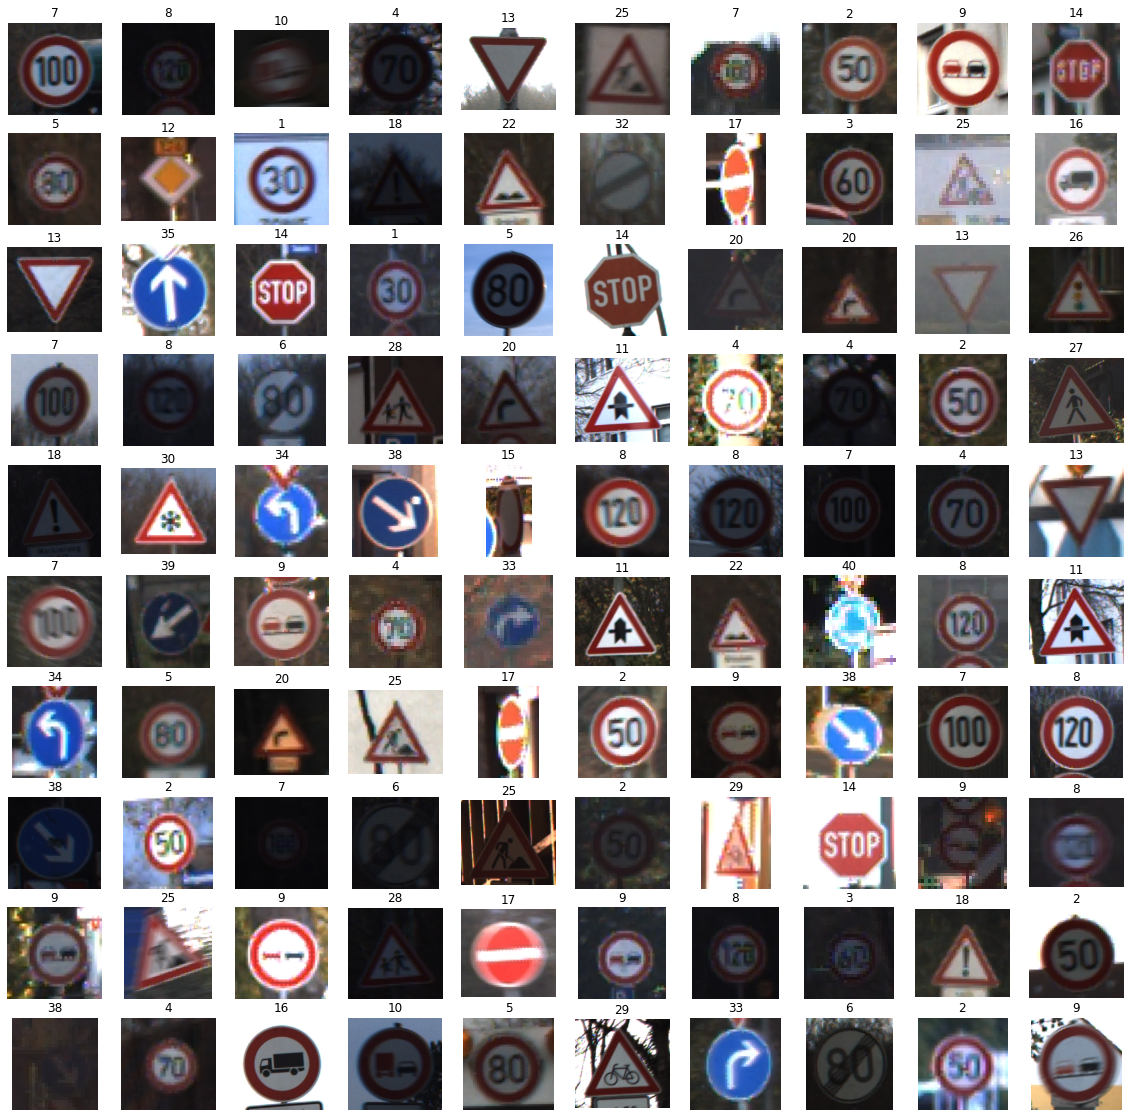

In [71]:
import os
import gc
import numpy as np
import pandas as pd
import random as rd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from pandas import read_csv
from PIL import Image as pil_image
%matplotlib inline

def show_sign(imgs, tags, per_row=2):
    n  = len(imgs) #几张图片
    rows = (n + per_row - 1)//per_row #地板除
    cols = min(per_row, n) #有可能有的数据一行就显示完了
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off') #关闭坐标轴
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())):  #把imgs和axes zip成一一对应元组
        ax.imshow(img.convert('RGB')) #画图
        ax.set_title(tags[i])

#抓取类名
def tag(i):
    try:
        m = trainlist[i].split('/')[8]
        return str(int(m)) # 0~42
    except:
        m = trainlist[i].split('/')[-1]
        n = m.split('\\')[1]
        return str(int(n))


#打开两层 /类名/图名 文件夹的遍历
trainlist = glob('/content/drive/MyDrive/kaggle/traffic_sign/data/train/*/*') 

### rd.randint(start,end)生成100次随机数
example = [rd.randint(0, len(trainlist)-1) for i in range(100)] 

#随机展示100张训练集图片
imgs = [pil_image.open(trainlist[_]) for _ in example]
tags = [tag(_) for _ in example]



show_sign(imgs, tags, per_row=10) #重写per_row

### 标签数据

下面我们看看每个数字ID分别对应的交通标志内容。该信息储存在 `./data/signnames.csv` 中， 我们使用 `pandas` 读取并储存该信息于字典 `sign_names` 中。

In [72]:
from prettytable import PrettyTable

sign_names = dict([(p,w) for _,p,w in read_csv('/content/drive/MyDrive/kaggle/traffic_sign/data/signnames.csv').to_records()])

sign_name_table = PrettyTable()
sign_name_table.field_names = ['class value', 'Name of Traffic sign']
for i, j in sign_names.items(): sign_name_table.add_row([i, j])

print(sign_name_table)

+-------------+----------------------------------------------------+
| class value |                Name of Traffic sign                |
+-------------+----------------------------------------------------+
|      0      |                Speed limit (20km/h)                |
|      1      |                Speed limit (30km/h)                |
|      2      |                Speed limit (50km/h)                |
|      3      |                Speed limit (60km/h)                |
|      4      |                Speed limit (70km/h)                |
|      5      |                Speed limit (80km/h)                |
|      6      |            End of speed limit (80km/h)             |
|      7      |               Speed limit (100km/h)                |
|      8      |               Speed limit (120km/h)                |
|      9      |                     No passing                     |
|      10     |    No passing for vehicles over 3.5 metric tons    |
|      11     |       Right-of-way

---
<a id='step1'></a>
## 步骤1：导入数据集

在下方的代码单元（cell）中，我们以灰度图的形式导入了交通标志图像的数据集：
- 我们将图像尺寸统一调整为 32$\times$32
- `train['features']`, `test['features']` - 包含图像文件的numpy数组
- `train['label']` - 包含分类标签的数组

In [73]:
SIZE = (32,32) #全部统一改成32*32，一个模型识别一个size
n_class = len(sign_names)

### 导入训练集
train = {}
train['features'] = []
train['label'] = []

print('Loading the training set:')
for sign in tqdm(range(n_class)): #设置进度条tqdm，zfill右对齐，前面填充0
    path = '/content/drive/MyDrive/kaggle/traffic_sign/data/train/' + str(sign).zfill(5) + '/*'
    for i in glob(path):
        img = pil_image.open(i)
        img = img.convert('L')  # 将图像转变为灰度图，也可以再刚开始导入的时候就定义一个通道
        train['features'].append(np.array(img.resize(SIZE)))
        train['label'].append(sign)
train['label'] = np.array(train['label'])

### 导入测试集
test = {}
test['features'] = []
test['label'] = []

print('Loading the testing set:')
path = '/content/drive/MyDrive/kaggle/traffic_sign/data/test/*'
for i in tqdm(glob(path)):
    img = pil_image.open(i)
    img = img.convert('L')
    test['features'].append(np.array(img.resize(SIZE)))

n_train, n_test = len(train['features']), len(test['features'])

### 对数据特征进行维度匹配以便导入神经网络
train['features'] = np.expand_dims(train['features'], axis=-1)
test['features'] = np.expand_dims(test['features'], axis=-1)

print('Total number of classes:{}'.format(n_class))
print('Number of training examples =',n_train)
print('Number of testing examples =',n_test)
print('Image data shape=',train['features'].shape[1:])

Loading the training set:


  0%|          | 0/43 [00:00<?, ?it/s]

Loading the testing set:


  0%|          | 0/12569 [00:00<?, ?it/s]

Total number of classes:43
Number of training examples = 26640
Number of testing examples = 12569
Image data shape= (32, 32, 1)


---
<a id='step2'></a>
## 步骤2：数据增强（可不做）

### 数据分布

通过频率直方图检查各个类别的数据量是否均衡

------- 
Highest count: 1500 (class 1)
Lowest count: 150 (class 0)
------- 


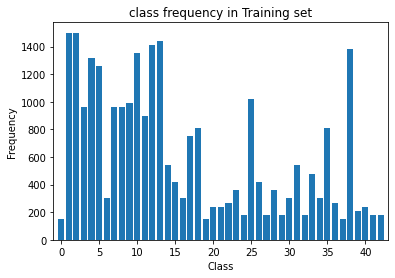

In [74]:
def get_count_imgs_per_class(y, verbose=False):
    num_classes = len(np.unique(y))
    count_imgs_per_class = np.zeros(num_classes)

    for this_class in range(num_classes):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum(y==this_class)))
        count_imgs_per_class[this_class] = np.sum(y==this_class)
    return count_imgs_per_class

class_freq = get_count_imgs_per_class(train['label'])
print('------- ')
print('Highest count: {} (class {})'.format(int(np.max(class_freq)), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(int(np.min(class_freq)), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(n_class), class_freq , align='center')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xlim([-1, n_class])
plt.title("class frequency in Training set")
plt.show()

### 数据增强

这里的数据增强主要是：
- 增加训练集的大小 
- 调整了类别分布（由上图可以看出类别分布是不均衡的） 

>参考CSDN博客文章：[在分类中如何处理训练集中不平衡问题](https://blog.csdn.net/heyongluoyao8/article/details/49408131)

---
<a id='question1'></a>  


数据增强后，我们得到每个类别2000张图片 数据增强的方法主要就是从原始数据集中随机选取图片，并应用仿射变换。
仿射变换的限制条件为：
- 旋转角度我限制在 `[-10，10]` 度之间，如果旋转角度过大，有些交通标志的意思可能就会发生变化
- 水平、垂直移动的话，范围限制在 `[-3, 3]` 像素之间
- 伸缩变换限制在 `[0.8, 1.2]` 之间

In [75]:
from skimage import transform as transf

### 仿射变换函数
def random_transform(img,angle_range=[-10,10],
                    scale_range=[0.8,1.2],
                    translation_range=[-3,3]):
    '''
    The function takes an image and performs a set of random affine transformation.
    img:original images
    ang_range:angular range of the rotation [-15,+15] deg for example
    scale_range: [0.8,1.2]
    shear_range:[10,-10]
    translation_range:[-2,2]
    '''
    img_height,img_width,img_depth = img.shape
    # Generate random parameter values
    angle_value = np.random.uniform(low=angle_range[0],high=angle_range[1],size=None)
    scaleX = np.random.uniform(low=scale_range[0],high=scale_range[1],size=None)
    scaleY = np.random.uniform(low=scale_range[0],high=scale_range[1],size=None)
    translationX = np.random.randint(low=translation_range[0],high=translation_range[1]+1,size=None)
    translationY = np.random.randint(low=translation_range[0],high=translation_range[1]+1,size=None)

    center_shift = np.array([img_height,img_width])/2. - 0.5
    transform_center = transf.SimilarityTransform(translation=-center_shift)
    transform_uncenter = transf.SimilarityTransform(translation=center_shift)

    transform_aug = transf.AffineTransform(rotation=np.deg2rad(angle_value),
                                          scale=(1/scaleY,1/scaleX),
                                          translation = (translationY,translationX))
    #Image transformation : includes rotation ,shear,translation,zoom
    full_tranform = transform_center + transform_aug + transform_uncenter
    new_img = transf.warp(img,full_tranform,preserve_range=True)

    return new_img.astype('uint8')

### 数据增强函数
def data_augmentation(X_dataset,y_dataset,augm_nbr,keep_dist=True):
    '''
    X_dataset:image dataset to augment
    y_dataset:label dataset
    keep_dist - True:keep class distribution of original dataset,
                False:balance dataset
    augm_param - is the augmentation parameter
                if keep_dist is True,increase the dataset by the factor 'augm_nbr' (2x,5x or 10x...)
                if keep_dist is False,make all classes have same number of images:'augm_nbr'(2500,3000 or 4000 imgs)
    '''
    X_train_dtype = X_dataset
    n_classes = len(np.unique(y_dataset))
    _,img_height,img_width,img_depth = X_dataset.shape
    class_freq = get_count_imgs_per_class(y_train)

    if keep_dist:
        extra_imgs_per_class = np.array([augm_nbr*x for x in get_count_imgs_per_class(y_dataset)])
    else:
        assert (augm_nbr>np.argmax(class_freq)),'augm_nbr must be larger than the height class count'
        extra_imgs_per_class = augm_nbr - get_count_imgs_per_class(y_dataset)

    total_extra_imgs = np.sum(extra_imgs_per_class)

    #if extra data is needed->run the dataaumentation op
    if total_extra_imgs > 0:
        X_extra = np.zeros((int(total_extra_imgs),img_height,img_width,img_depth),dtype=X_dataset.dtype)
        y_extra = np.zeros(int(total_extra_imgs))
        start_idx = 0
        #print('start data augmentation.....')
        for this_class in range(n_classes):
            #print('\t Class {}|Number of extra imgs{}'.format(this_class,int(extra_imgs_per_class[this_class])))
            n_extra_imgs = extra_imgs_per_class[this_class]
            end_idx = start_idx + n_extra_imgs

            if n_extra_imgs > 0:
                #get ids of all images belonging to this_class
                all_imgs_id = np.argwhere(y_dataset==this_class)
                new_imgs_x = np.zeros((int(n_extra_imgs),img_height,img_width,img_depth))

                for k in range(int(n_extra_imgs)):
                    #randomly pick an original image belonging to this class
                    rand_id = np.random.choice(all_imgs_id[0],size=None,replace=True)
                    rand_img = X_dataset[rand_id]
                    #Transform image
                    new_img = random_transform(rand_img)
                    new_imgs_x[k,:,:,:] = new_img
                #update tensors with new images and associated labels
                X_extra[int(start_idx):int(end_idx)] = new_imgs_x
                y_extra[int(start_idx):int(end_idx)] = np.ones((int(n_extra_imgs),))*this_class
                start_idx = end_idx
        return [X_extra,y_extra]
    else:
        return [None,None]

*** Before data augmentation:
Train set size:21312|Validation set size:5328

*** After data augmentation:
Train set size:86000|Validation set size:5328



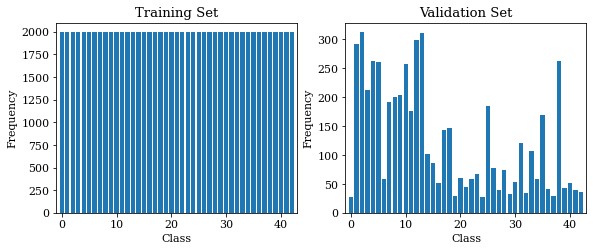

In [76]:
# TODO: import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# TODO: split the data into training and validation subsets
X_train, X_valid, y_train, y_valid= train_test_split(train['features'], train['label'], test_size=0.2, random_state=42)
# X_train = X_train.astype(float)
# X_valid = X_valid.astype(float)

print('*** Before data augmentation:')
print('Train set size:{}|Validation set size:{}\n'.format(X_train.shape[0],X_valid.shape[0]))

X_extra,y_extra = data_augmentation(X_train,y_train,augm_nbr=2000,keep_dist=False)

if X_extra is not None:
    X_train = np.concatenate((X_train,X_extra.astype('uint8')),axis=0)
    y_train = np.concatenate((y_train,y_extra),axis=0)
    del X_extra,y_extra

print('*** After data augmentation:')
print('Train set size:{}|Validation set size:{}\n'.format(X_train.shape[0],X_valid.shape[0]))

with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 11}):
    fig = plt.figure(figsize=(9.5,3.5))
    ax1 = fig.add_subplot(121)
    plt.bar(np.arange(n_class),get_count_imgs_per_class(y_train),align='center')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Training Set')
    plt.xlim([-1,43])
    ax2 = fig.add_subplot(122)
    plt.bar(np.arange(n_class),get_count_imgs_per_class(y_valid),align='center')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Validation Set')
    plt.xlim([-1,43])

---
<a id='step3'></a>
## 步骤 3: CNN模型构建

在对图像进行增强之后，我们需要更进一步的方法，来对标志的类别进行识别。在这一步中，你需要实现一个卷积神经网络来对交通标志图像进行分类。你需要从头实现你的卷积神经网络。

需要注意的是，在添加卷积层的时候，注意不要加上太多的（可训练的）层。更多的参数意味着更长的训练时间，也就是说你更可能需要一个 GPU 来加速训练过程。万幸的是，Keras 提供了能够轻松预测每次迭代（epoch）花费时间所需的函数。你可以据此推断你算法所需的训练时间。

### 数据预处理

由于图像像素值分布在 `0-255` 之间，数值较大，因此在将数据导入神经网络之前，我们需要对图像数组进行归一化处理。同时我们需要将标签进行独热编码。

In [77]:
def preprocessed(dataset):
    n_imgs,img_height,img_width,_ = dataset.shape
    processed_dataset = np.zeros((n_imgs,img_height,img_width,1))
    for i in range(len(dataset)):
        img = dataset[i]
        processed_dataset[i,:,:,:] = img/255.-0.5 #把数值换到（-1，1）之间 一般彩色图片可以用imagenet
    return processed_dataset

X_train, X_valid = preprocessed(X_train), preprocessed(X_valid)

In [78]:
import torch
from torch.utils.data import Dataset, DataLoader

class TrafficDataset(Dataset): # from torch.utils.data import Dataset
    def __init__(self, data, label):
      self.data = data
      self.label = label
        
    def __getitem__(self, index):
      feature = torch.FloatTensor(self.data[index]).permute(2,0,1) #eg. X_train[1] 2列到0列，其他整体挪动
      target = int(self.label[index]) #eg. y_train[1]
      return feature, target
    
    def __len__(self):
      return self.data.shape[0]
        

In [79]:
bs = 256

#封装
train_loader = DataLoader(TrafficDataset(X_train, y_train), batch_size=bs, shuffle=True, num_workers=0)
valid_loader = DataLoader(TrafficDataset(X_valid, y_valid), batch_size=bs, shuffle=True, num_workers=0)
test_loader  = DataLoader(TrafficDataset(test['features'], None), batch_size=bs, shuffle=False, num_workers=0)

In [80]:
#check dataloader,取一个查看
for x,y in train_loader:
  break

In [81]:
x.shape #bs,channel,width,height

torch.Size([256, 1, 32, 32])

### 【练习】CNN模型架构


创建一个卷积神经网络来对交通标志进行分类。在你代码块的最后，执行 `model.summary()` 来输出你模型的总结信息。
    
我们已经帮你导入了一些所需的 Python 库，如有需要你可以自行导入。如果你在过程中遇到了困难，请查阅[Keras英文文档](https://keras.io/)。

在这里可以尝试采用经典的 LeNet-5 架构，如下图所示：


参考结构如下：

01. 5x5 convolution (32x32x1 in, 28x28x6 out)
02. ReLU
03. 2x2 max pool (28x28x6 in, 14x14x6 out)
04. 5x5 convolution (14x14x6 in, 10x10x16 out)
05. ReLU
06. 2x2 max pool (10x10x16 in, 5x5x16 out)
07. 5x5 convolution (5x5x16 in, 1x1x400 out)
08. ReLU
09. Flatten layers from numbers 8 (1x1x400 -> 400) and 6 (5x5x16 -> 400)
10. Concatenate flattened layers to a single size-800 layer
11. Dropout layer
12. Fully connected layer (800 in, 43 out)

>**Note: 这里必须采用函数式写法构建 CNN [参考链接](https://keras.io/models/model/)

In [82]:
import torch
from torch import nn, optim
from torch.nn import functional as F

In [83]:
class TrafficNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        ## TODO
        self.num_classes = num_classes
        self.conv0 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5) #1. 5x5 convolution (32x32x1 in, 28x28x6 out)
                                           #2. ReLU
        self.pool0 = nn.MaxPool2d(2)                    #3. 2x2 max pool (28x28x6 in, 14x14x6 out)
        self.conv1 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5) #4. 5x5 convolution (14x14x6 in, 10x10x16 out)
                                           #5. ReLU
        self.pool1 = nn.MaxPool2d(2)                    #6. 2x2 max pool (10x10x16 in, 5x5x16 out)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=400,kernel_size=5) #7. 5x5 convolution (5x5x16 in, 1x1x400 out)
                                           #8. ReLU
                                           #9. Flatten layers from numbers 8 (1x1x400 -> 400) and 6 (5x5x16 -> 400)
                                           #10. Concatenate flattened layers to a single size-800 layer
        self.dropout = nn.Dropout(0.2)                   #11. Dropout layer
        self.fc = nn.Linear(800,num_classes)                #12. Fully connected layer (800 in, 43 out)

    def forward(self, x): #forward函数里不能写需要训练的带参数层，但是可以嵌套relu等函数
        ## TODO
        # x = x.type(torch.FloatTensor)
        x = self.pool0(torch.relu(self.conv0(x))) #1-3
        x = self.pool1(torch.relu(self.conv1(x))) #4-6
        x1 = torch.relu(self.conv2(x)) #7-8
        x2 = torch.flatten(x,start_dim=1) #9, flatten from dimension 6.'channel' [bs,channel,height,width]
        x3 = torch.flatten(x1,start_dim=1) #9, flatten from dimension 8.'channel' 
        x = torch.cat([x2,x3],dim=1) #10
        x = self.dropout(x) #11
        x = self.fc(x) #12

        return x

In [84]:
model = TrafficNet(num_classes=n_class)

In [85]:
model

TrafficNet(
  (conv0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 400, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=800, out_features=43, bias=True)
)

---
<a id='step4'></a>
## 步骤4：模型训练

模型训练过程中我们使用了早期停止来防止过拟合，并使用学习率衰减寻找局部最优解。

---


In [86]:
if not os.path.exists('models'):
    os.makedirs('models') # 用于储存模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [87]:
criterion = nn.CrossEntropyLoss() #pytorch处理单标签多分类问题
model = model.to(device)

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

In [88]:
def train_model(epoch, history=None):
    model.train() 
    t = tqdm(train_loader)
    
    for batch_idx, (img_batch, label_batch) in enumerate(t):

        img_batch = img_batch.to(device) #导入gpu
        label_batch = label_batch.to(device)

        img_batch = img_batch.cuda()
        label_batch = label_batch.cuda()

        optimizer.zero_grad() #梯度清零
        output = model(img_batch)
        loss = criterion(output, label_batch)
        t.set_description(f'train_loss (l={loss:.4f})')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward() #算出梯度值
        optimizer.step() #参数更新
    
    torch.save(model.state_dict(), 'models/epoch{}.pth'.format(epoch))

In [89]:
from sklearn.metrics import accuracy_score

#少了梯度更新过程，只是做inference
def evaluate(epoch, history=None): # 验证函数
    model.eval() # 开启验证模式，此时模型的参数不可修改
    valid_loss = 0.
    all_predictions, all_targets = [], []
    
    with torch.no_grad():
        for batch_idx, (img_batch, label_batch) in enumerate(valid_loader):
            all_targets.append(label_batch.numpy().copy())
            img_batch = img_batch.to(device)
            label_batch = label_batch.to(device)

            output = model(img_batch)
            loss = criterion(output, label_batch)
            valid_loss += loss.data
            predictions = torch.argmax(torch.softmax(output, axis=-1), axis=-1)
            all_predictions.append(predictions.cpu().numpy())
            
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    
    valid_loss /= (batch_idx+1)
    valid_acc = accuracy_score(all_targets, all_predictions)
    
    if history is not None:
        history.loc[epoch, 'valid_loss'] = valid_loss.cpu().numpy()
    
    print('Epoch: {}\tLR: {:.6f}\tValid Loss: {:.4f}\tValid Acc: {:.4f}'.format(
        epoch, optimizer.state_dict()['param_groups'][0]['lr'], valid_loss, valid_acc))
    
    return valid_loss, valid_acc

In [90]:
history_train = pd.DataFrame()
history_valid = pd.DataFrame()

n_epochs = 100
init_epoch = 0
max_lr_changes = 2
valid_losses = []
valid_accs = []
lrs = []
lr_reset_epoch = init_epoch
patience = 3
lr_changes = 0
best_valid_loss = 1000.

for epoch in range(init_epoch, n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history_train)
    valid_loss, valid_acc = evaluate(epoch, history_valid)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    elif (patience and epoch - lr_reset_epoch > patience and
          min(valid_losses[-patience:]) > best_valid_loss):
        # "patience" epochs without improvement
        lr_changes +=1
        if lr_changes > max_lr_changes: # 早期停止
            break
        lr /= 5 # 学习率衰减，改学习率效果变好
        print(f'lr updated to {lr}')
        lr_reset_epoch = epoch
        optimizer.param_groups[0]['lr'] = lr
    
    lrs.append(optimizer.param_groups[0]['lr'])

  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 0	LR: 0.001000	Valid Loss: 1.8453	Valid Acc: 0.4703


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 1	LR: 0.001000	Valid Loss: 0.9681	Valid Acc: 0.7158


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 2	LR: 0.001000	Valid Loss: 0.6227	Valid Acc: 0.8102


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 3	LR: 0.001000	Valid Loss: 0.4350	Valid Acc: 0.8711


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 4	LR: 0.001000	Valid Loss: 0.3409	Valid Acc: 0.8985


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 5	LR: 0.001000	Valid Loss: 0.2491	Valid Acc: 0.9270


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 6	LR: 0.001000	Valid Loss: 0.2281	Valid Acc: 0.9345


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 7	LR: 0.001000	Valid Loss: 0.1950	Valid Acc: 0.9399


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 8	LR: 0.001000	Valid Loss: 0.1486	Valid Acc: 0.9615


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 9	LR: 0.001000	Valid Loss: 0.1175	Valid Acc: 0.9733


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 10	LR: 0.001000	Valid Loss: 0.1253	Valid Acc: 0.9688


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 11	LR: 0.001000	Valid Loss: 0.1196	Valid Acc: 0.9698


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 12	LR: 0.001000	Valid Loss: 0.1089	Valid Acc: 0.9777


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 13	LR: 0.001000	Valid Loss: 0.1118	Valid Acc: 0.9756


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 14	LR: 0.001000	Valid Loss: 0.1234	Valid Acc: 0.9718


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 15	LR: 0.001000	Valid Loss: 0.1198	Valid Acc: 0.9720
lr updated to 0.0002


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 16	LR: 0.000200	Valid Loss: 0.0757	Valid Acc: 0.9861


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 17	LR: 0.000200	Valid Loss: 0.0730	Valid Acc: 0.9859


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 18	LR: 0.000200	Valid Loss: 0.0710	Valid Acc: 0.9874


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 19	LR: 0.000200	Valid Loss: 0.0740	Valid Acc: 0.9863


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 20	LR: 0.000200	Valid Loss: 0.0681	Valid Acc: 0.9889


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 21	LR: 0.000200	Valid Loss: 0.0674	Valid Acc: 0.9884


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 22	LR: 0.000200	Valid Loss: 0.0752	Valid Acc: 0.9865


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 23	LR: 0.000200	Valid Loss: 0.0745	Valid Acc: 0.9870


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 24	LR: 0.000200	Valid Loss: 0.0695	Valid Acc: 0.9880
lr updated to 4e-05


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 25	LR: 0.000040	Valid Loss: 0.0686	Valid Acc: 0.9893


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 26	LR: 0.000040	Valid Loss: 0.0682	Valid Acc: 0.9893


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 27	LR: 0.000040	Valid Loss: 0.0692	Valid Acc: 0.9897


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch: 28	LR: 0.000040	Valid Loss: 0.0688	Valid Acc: 0.9887


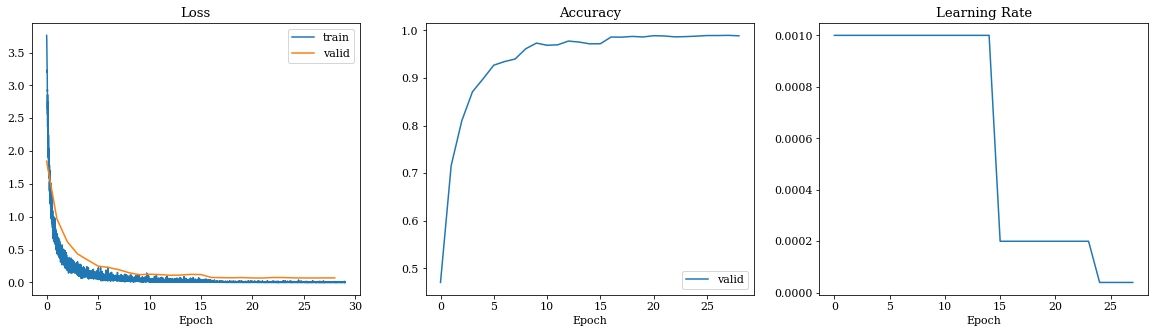

In [91]:
# 绘制损失函数、精确率与学习速率的变化曲线
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 11}):
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(131)
    ax1.set_xlabel('Epoch')
    ax1.set_title('Loss')
    plt.plot(history_train.index, history_train['train_loss'])
    plt.plot(history_valid.index, history_valid['valid_loss'])
    plt.legend(['train', 'valid'], loc='upper right')
    ax2 = fig.add_subplot(132)
    ax2.set_xlabel('Epoch')
    ax2.set_title('Accuracy')
    plt.plot(valid_accs)
    plt.legend(['valid'], loc='lower right')
    ax3 = fig.add_subplot(133)
    ax3.set_xlabel('Epoch')
    ax3.set_title('Learning Rate')
    plt.plot(lrs)